In [1]:
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
analysis_directory = "analysis"

def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def create_file_path(directory, file_name):
    file_path = os.path.join(directory, file_name)
    return file_path

def parse_train_line(line):
    batch = None
    batch_match = re.search("\[batch =(.+?)\] ", line)
    if (batch_match and len(batch_match.groups()) == 1):
        batch = int(batch_match.groups()[0].strip())
    perplexity = None
    perplexity_match = re.search("\] train_perplexity =(.+?),", line)
    if (perplexity_match and len(perplexity_match.groups()) == 1):
        perplexity = float(perplexity_match.groups()[0].strip())
    loss = None
    loss_match = re.search(", train_loss =(.+?),", line)
    if (loss_match and len(loss_match.groups()) == 1):
        loss = float(loss_match.groups()[0].strip())
    return (batch, perplexity, loss)

def parse_validation_line(line):
    epoch = None
    epoch_match = re.search("\[epoch =(.+?)\] ", line)
    if (epoch_match and len(epoch_match.groups()) == 1):
        epoch = int(epoch_match.groups()[0].strip())
    perplexity = None
    perplexity_match = re.search("\] validation_perplexity =(.+?),", line)
    if (perplexity_match and len(perplexity_match.groups()) == 1):
        perplexity = float(perplexity_match.groups()[0].strip())
    loss = None
    loss_match = re.search(", validation_loss =(.+?)\n", line)
    if (loss_match and len(loss_match.groups()) == 1):
        loss = float(loss_match.groups()[0].strip())
    return (epoch, perplexity, loss)

def read_and_parse_validation_data(file_path):
    validation_lines = [parse_validation_line(line) for line in open(file_path) if "] validation_" in line]
    epochs = [entry[0] for entry in validation_lines]
    perplexities = [entry[1] for entry in validation_lines]
    return (epochs, perplexities)

def read_and_parse_train_data(file_path):
    train_lines = [parse_train_line(line) for line in open(file_path) if "] train_" in line]
    batches = [entry[0] for entry in train_lines]
    min_batch = min(batches)
    max_batch = max(batches)
    batches = None
    epoch = 0
    epochs = []
    perplexities = []
    batch_perplexities = []
    for entry in train_lines:
        batch, perplexity, loss = entry
        if (batch == max_batch):
            epoch += 1
            epochs.append(epoch)
            epoch_perplexity = sum(batch_perplexities) / float(len(batch_perplexities))
            perplexities.append(epoch_perplexity)
            batch_perplexities = []
        else:
            batch_perplexities.append(perplexity)
    return (epochs, perplexities)
        
def read_and_parse_test_perplexity(file_path):
    test_lines = [line for line in open(file_path) if "test_perplexity =" in line]
    test_perplexity = None
    if (len(test_lines) == 1):
        test_perplexity_match = re.search("test_perplexity =(.+?),", test_lines[0])
        if (test_perplexity_match and len(test_perplexity_match.groups()) == 1):
            test_perplexity = float(test_perplexity_match.groups()[0].strip())
    return test_perplexity

def parse_annealing_learning_rate_line(line):
    epoch = None
    epoch_match = re.search("\[epoch =(.+?)\] ", line)
    if (epoch_match and len(epoch_match.groups()) == 1):
        epoch = int(epoch_match.groups()[0].strip())
    learning_rate = None
    learning_rate_match = re.search("] annealing learning_rate =(.+?)\n", line)
    if (learning_rate_match and len(learning_rate_match.groups()) == 1):
        learning_rate = float(learning_rate_match.groups()[0].strip())
    return (epoch, learning_rate)
    
def read_and_parse_annealing_learning_rates(file_path):
    annealing_learning_rates = [parse_annealing_learning_rate_line(line) for line in open(file_path) if "] annealing learning_rate =" in line]
    epochs = [entry[0] for entry in annealing_learning_rates]
    learning_rates = [entry[1] for entry in annealing_learning_rates]
    return (epochs, learning_rates)

def parse_total_training_time(line):
    training_time = None
    training_time_match = re.search("Total training time:(.+?)\n", line)
    if (training_time_match and len(training_time_match.groups()) == 1):
        training_time = training_time_match.groups()[0].strip()
    return training_time

def read_and_parse_total_training_time(file_path):
    training_time = [parse_total_training_time(line) for line in open(file_path) if "Total training time:" in line]
    return training_time

create_directory_if_not_exists(analysis_directory)

In [3]:
char_gru_file_name = create_file_path("e100", "ptb_char_gru.txt")
word_gru_file_name = create_file_path("e100", "ptb_word_gru.txt")
char_lstm_file_name = create_file_path("e100", "ptb_char_lstm.txt")
word_lstm_file_name = create_file_path("e100", "ptb_word_lstm.txt")

In [4]:
char_gru_total_training_time = read_and_parse_total_training_time(char_gru_file_name)
char_lstm_total_training_time = read_and_parse_total_training_time(char_lstm_file_name)
word_gru_total_training_time = read_and_parse_total_training_time(word_gru_file_name)
word_lstm_total_training_time = read_and_parse_total_training_time(word_lstm_file_name)
("char_gru", char_gru_total_training_time,
 "char_lstm", char_lstm_total_training_time,
 "word_gru", word_gru_total_training_time,
 "word_lstm", word_lstm_total_training_time)

('char_gru',
 ['78m 8s'],
 'char_lstm',
 ['88m 33s'],
 'word_gru',
 ['18m 3s'],
 'word_lstm',
 ['18m 29s'])

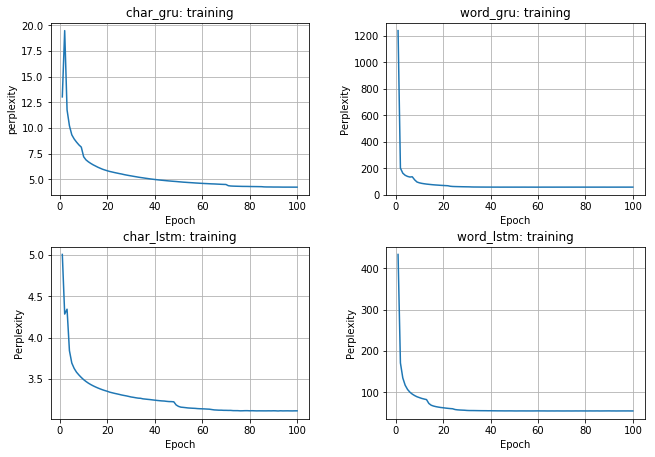

In [5]:
plt.figure(1)

# char gru
plt.subplot(221)
char_gru = read_and_parse_train_data(char_gru_file_name)
plt.plot(char_gru[0], char_gru[1])
plt.title("char_gru: training")
plt.xlabel("Epoch")
plt.ylabel("perplexity")
plt.grid(True)

# word gru
plt.subplot(222)
word_gru = read_and_parse_train_data(word_gru_file_name)
plt.plot(word_gru[0], word_gru[1])
plt.title("word_gru: training")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)

# char lstm
plt.subplot(223)
char_lstm = read_and_parse_train_data(char_lstm_file_name)
plt.plot(char_lstm[0], char_lstm[1])
plt.title("char_lstm: training")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)

# word lstm
plt.subplot(224)
word_lstm = read_and_parse_train_data(word_lstm_file_name)
plt.plot(word_lstm[0], word_lstm[1])
plt.title("word_lstm: training")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)

plt.subplots_adjust(top = 1.5, right = 1.5, wspace = 0.3, hspace = 0.3)
image_file_path = create_file_path(analysis_directory, "training_comparison.png")
plt.savefig(image_file_path, bbox_inches = "tight")

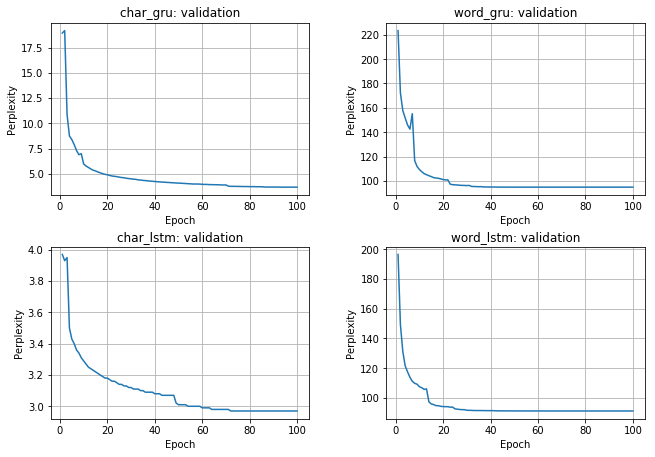

In [6]:
plt.figure(1)

# char gru
plt.subplot(221)
char_gru = read_and_parse_validation_data(char_gru_file_name)
plt.plot(char_gru[0], char_gru[1])
plt.title("char_gru: validation")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)

# word gru
plt.subplot(222)
word_gru = read_and_parse_validation_data(word_gru_file_name)
plt.plot(word_gru[0], word_gru[1])
plt.title("word_gru: validation")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)

# char lstm
plt.subplot(223)
char_lstm = read_and_parse_validation_data(char_lstm_file_name)
plt.plot(char_lstm[0], char_lstm[1])
plt.title("char_lstm: validation")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)

# word lstm
plt.subplot(224)
word_lstm = read_and_parse_validation_data(word_lstm_file_name)
plt.plot(word_lstm[0], word_lstm[1])
plt.title("word_lstm: validation")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)

plt.subplots_adjust(top = 1.5, right = 1.5, wspace = 0.3, hspace = 0.3)
image_file_path = create_file_path(analysis_directory, "validation_comparison.png")
plt.savefig(image_file_path, bbox_inches = "tight")

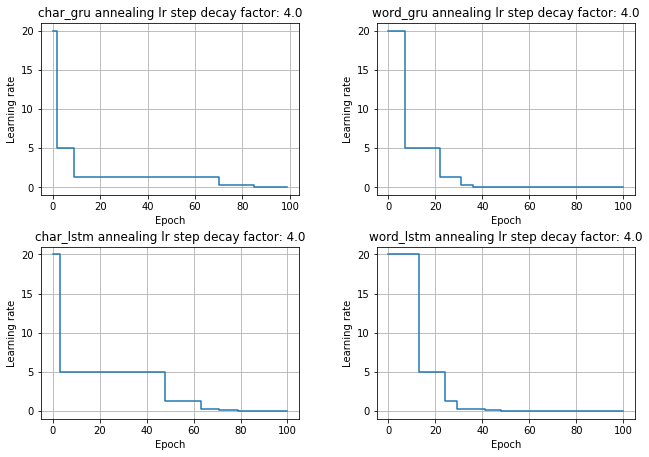

In [7]:
plt.figure(1)

# char gru
plt.subplot(221)
char_gru_learning_rates = read_and_parse_annealing_learning_rates(char_gru_file_name)
char_gru_epoch_list = [0] + char_gru_learning_rates[0]
char_gru_learning_rate_list = [20.0] + char_gru_learning_rates[1]
plt.step(char_gru_epoch_list, char_gru_learning_rate_list, where = "post")
plt.title("char_gru annealing lr step decay factor: 4.0")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.grid(True)

# word gru
plt.subplot(222)
word_gru_learning_rates = read_and_parse_annealing_learning_rates(word_gru_file_name)
word_gru_epoch_list = [0] + word_gru_learning_rates[0]
word_gru_learning_rate_list = [20.0] + word_gru_learning_rates[1]
plt.step(word_gru_epoch_list, word_gru_learning_rate_list, where = "post")
plt.title("word_gru annealing lr step decay factor: 4.0")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.grid(True)

# char lstm
plt.subplot(223)
char_lstm_learning_rates = read_and_parse_annealing_learning_rates(char_lstm_file_name)
char_lstm_epoch_list = [0] + char_lstm_learning_rates[0]
char_lstm_learning_rate_list = [20.0] + char_lstm_learning_rates[1]
plt.step(char_lstm_epoch_list, char_lstm_learning_rate_list, where = "post")
plt.title("char_lstm annealing lr step decay factor: 4.0")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.grid(True)

# word lstm
plt.subplot(224)
word_lstm_learning_rates = read_and_parse_annealing_learning_rates(word_lstm_file_name)
word_lstm_epoch_list = [0] + word_lstm_learning_rates[0]
word_lstm_learning_rate_list = [20.0] + word_lstm_learning_rates[1]
plt.step(word_lstm_epoch_list, word_lstm_learning_rate_list, where = "post")
plt.title("word_lstm annealing lr step decay factor: 4.0")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.grid(True)

plt.subplots_adjust(top = 1.5, right = 1.5, wspace = 0.3, hspace = 0.3)
image_file_path = create_file_path(analysis_directory, "annealing_comparison.png")
plt.savefig(image_file_path, bbox_inches = "tight")

In [8]:
char_gru_test_perplexity = read_and_parse_test_perplexity(char_gru_file_name)
char_lstm_test_perplexity = read_and_parse_test_perplexity(char_lstm_file_name)
word_gru_test_perplexity = read_and_parse_test_perplexity(word_gru_file_name)
word_lstm_test_perplexity = read_and_parse_test_perplexity(word_lstm_file_name)
("char_gru", char_gru_test_perplexity,
 "char_lstm", char_lstm_test_perplexity,
 "word_gru", word_gru_test_perplexity,
 "word_lstm", word_lstm_test_perplexity)

('char_gru', 3.63, 'char_lstm', 2.91, 'word_gru', 90.89, 'word_lstm', 87.08)